<a href="https://colab.research.google.com/github/TheAnders121/TestRepo/blob/main/ProjektKode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import os
import datetime
import time

from datetime import datetime, timedelta

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler
import json
import requests

**Configurations**

In [ ]:
MAX_EPOCHS = 20

multi_val_performance = {}
multi_performance = {}

inputTransformer = RobustScaler()
outputTransformer = RobustScaler()

#Paths
model_path = '/content/saved_model/my_model'
plot_path = ''
historical_data = 'data.csv'
rData_path = 'data.csv'
wData_path = ''

#Model columns
direct = 'DirectSunPower kW/m²'
diffused = 'DiffuseSunPower kW/m²'
sunAltitude = 'SunAltitude °'
inputColumn = sunAltitude
outputColumn = diffused

#Model construction
steps = 24
inputColumns = 2
inputShape = [steps, inputColumns]

#Model compilation, fitting and optimization
optimizationAlgorithm = tf.keras.optimizers.Adam()

#API paths 
POST = 'somePath'
GET = 'somePath'

#Scheduler
hours = 1


**Data windowing**

**Split data**

In [ ]:
def splitData(data):
  n = len(data)
  train = data[0:int(n*0.9)] #first 90%
  test = data[int(n*0.9):] #left over 10%
  return [train, test]

**Create dataset**

In [ ]:
def createDatasets(input, output, timeSteps):
  inputList, outputList = [], []
  for i in range(len(input) - timeSteps):
    val = input.iloc[i: (i + timeSteps)].to_numpy()
    inputList.append(val)
    outputList.append(output.iloc[i + timeSteps])
  return np.array(inputList), np.array(outputList)

**Reshape data**

In [ ]:
def reshapeData(data, steps):
  input, output = createDatasets(data, data[outputColumn], steps)
  return [input, output]

**Transform data**

In [ ]:
def transformData(data, column):
  transformer = RobustScaler()
  transformer = transformer.fit(data[column].to_numpy())
  data.loc[:, column] = transformer.transform(data[column].to_numpy())
  return data

**Inverse transform data**

In [ ]:
def inverseTransformData(data, column=''):
  transformer = RobustScaler()
  if column == '':
    transformer = transformer.fit(data) 
  else:
    transformer = transformer.fit(data[column])
  
  inversed = transformer.inverse_transform(data)
  return inversed

**To json string**

In [ ]:
def toJson(string):
  return json.dumps(string)

**Convert Json string**

In [ ]:
def toNormal(string):
  return json.loads(string)

**Write predictions to file**

In [ ]:
def writePredictions(string):
  # Append-adds at last
  file1 = open(wData_path, "w")  #write mode (overwrite previous predictions)
  file1.write(string)
  file1.close()

**Upload predictions**

In [ ]:
def uploadPredictions(): 
  api_url = POST
  todo = {"userId": 1, "title": "Buy milk", "completed": False} #this should actually be a file with new predictions
  response = requests.post(api_url, json=todo)
  return response.status_code

**Build model**

In [ ]:
def buildModel():
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128, 
        input_shape=inputShape
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  return model

**Compile**

In [ ]:
def compile(model, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizationAlgorithm,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  return model

**Fit model**

In [ ]:
def fit(model, input, output):
  history = model.fit(
    input, output,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
  )
  return history

**Save weights**

**Load weights**

**Save model**

In [ ]:
#model - model that is to be saved (needs to be a tf.keras.model object)
#path - under which path the model will be saved (and can be accessed)
def save_model(model, path):
  model.save(path)

**Load model**

In [ ]:
#path - under which path the model will be accessible
def load_model(path):
  new_model = tf.keras.models.load_model(path)

  return new_model

**Load data**

In [ ]:
#path - path to where the data is to be loaded from 
def load_data(path):
  dt = pd.read_csv(path, sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')
  return dt

**Process data**

In [ ]:
#data - data that is to be processed in order for the model to read it
def process_data(data):
  # Convert to radians.
  data[sunAltitude] = data[sunAltitude]*np.pi / 180
  #data[[diffused, sunAltitude]].copy() #return only two relevant columns
  #return data[[sunAltitude]].copy() #return only relevant column
  return data

**Predict**

In [ ]:
#data - 48 datapoints for the model to predict the next 24 datapoints
def make_prediction(model, data, plot):
  if plot == False:
    prediction = model.predict(data)
    return prediction
  #Code to return plot 


**Send prediction**

**Main function**

In [ ]:

print("Hello from main")

'''
while True:
  #Do work
  data = process_data(load_data(rData_path))
  data = reshapeData(data, steps)
  tData = transformData(data)
  model = load_model(model_path)
  predictions = make_prediction(model, data, False)
  jsonString = toJson(inverseTransformData(predictions))
  code = uploadPredictions()
  #check status code 

  
  time.sleep(3600 * hours)  # do work every x amount of hours
'''



Hello from main


'\nwhile True:\n  #Do work\n  data = process_data(load_data(rData_path))\n  data = reshapeData(data, steps)\n  tData = transformData(data)\n  model = load_model(model_path)\n  predictions = make_prediction(model, data, False)\n  jsonString = toJson(inverseTransformData(predictions))\n  code = uploadPredictions()\n  #check status code \n\n  \n  time.sleep(3600 * hours)  # do work every x amount of hours\n'

**Unzip file**

In [ ]:
!unzip /content/LSTM_Model.zip

unzip:  cannot find or open /content/LSTM_Model.zip, /content/LSTM_Model.zip.zip or /content/LSTM_Model.zip.ZIP.


**Load test data**

In [ ]:
dt = pd.read_csv('data.csv', sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')

dt['SunAltitude °'] = dt['SunAltitude °']*np.pi / 180 #Get radians

diffuseSunData = dt[['DiffuseSunPower kW/m²','SunAltitude °']].copy()

n = len(diffuseSunData)
train_diffuseSunData = diffuseSunData[0:int(n*0.7)] #first 70%
val_diffuseSunData = diffuseSunData[int(n*0.7):int(n*0.9)] #following 20%
test_diffuseSunData = diffuseSunData[int(n*0.9):] #left over 10%

**Normalize data** 

In [ ]:
train_mean = diffuseSunData.mean()
train_var = diffuseSunData.var()

train_diffuseSunData = (train_diffuseSunData - train_mean) / train_var
val_diffuseSunData = (val_diffuseSunData - train_mean) / train_var
test_diffuseSunData = (test_diffuseSunData - train_mean) / train_var

**Denormalize**

In [ ]:
def denormalize(data):
  min_d = np.min(data)
  max_d = np.max(data)
  return (data - min_d) / (max_d - min_d)

**Model construction (currently single-step)**

In [ ]:

data = load_data(historical_data)
data = data[[inputColumn, outputColumn]].copy()
data = process_data(data)
data = splitData(data)
print(data[1])
train = transformData(data[0], [inputColumn, outputColumn])
test = transformData(data[1], [inputColumn, outputColumn])
print(test)
input, output = createDatasets(train, train[outputColumn], steps)

print(f'Dataset shape set to: {input.shape, output.shape}')
print(f'Set model input shape to: {input.shape[1], input.shape[2]}')
'''
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(input.shape[1], input.shape[2])))
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(input.shape[1], input.shape[2])))
model.add(tf.keras.layers.LSTM(units=32, input_shape=(input.shape[1], input.shape[2])))
model.add(keras.layers.Dense(units=1))
model.summary()
'''

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(input.shape[1], input.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

#model = compile(model)
#model.compile(loss='mean_squared_error', optimizer='adam')
history = fit(model, input, output)

testInput, testOutput = createDatasets(test, test[outputColumn], steps)

print(f'Test data shape: {testInput.shape}')
prediction = make_prediction(model, testInput, False)
print(prediction)

print(f'Prediction output shape: {inverseTransformData(prediction).shape}')
print(f'Prediction values: {inverseTransformData(prediction)}')
print(f'Real values: {data[1].tail(20)}')
#print(f'Real values: {inverseTransformData(np.reshape(testOutput,(-1,1)))}')
look = inverseTransformData(np.reshape(testOutput,(-1,1)))
#print(look[-20:, :])
#print(f'Shapes {testOutput.shape, look.shape}')
plt.plot(inverseTransformData(np.reshape(testOutput,(-1,1))).flatten(), marker='.', label='true')
plt.plot(inverseTransformData(prediction).flatten(), 'r', label='predicted')
plt.legend()

'''
print(train_diffuseSunData['DiffuseSunPower kW/m²'])

history = model.fit(train_diffuseSunData['SunAltitude °'],train_diffuseSunData['DiffuseSunPower kW/m²'], epochs=10)

model.evaluate(test_diffuseSunData['SunAltitude °'],test_diffuseSunData['DiffuseSunPower kW/m²'])

prediction = model.predict(train_diffuseSunData['SunAltitude °'])
print(prediction)

#print(denormalize(train_diffuseSunData['SunAltitude °']))

print(train_diffuseSunData['DiffuseSunPower kW/m²'])

from sklearn import metrics
metrics.mean_squared_error(train_diffuseSunData['DiffuseSunPower kW/m²'], prediction)

'''

Shapes ((1502,), (1502, 1))


**Model construction (multi-step)**

0     0.12
1     0.15
2     0.14
3     0.12
4     0.08
5     0.03
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
13    0.00
14    0.00
15    0.00
16    0.00
17    0.00
18    0.00
19    0.01
20    0.03
21    0.06
22    0.10
23    0.11
24    0.11
25    0.13
26    0.14
27    0.12
28    0.07
Name: DiffuseSunPower kW/m², dtype: float64
0    0.11
1    0.13
2    0.14
3    0.12
4    0.07
Name: DiffuseSunPower kW/m², dtype: float64
15248   NaN
15249   NaN
15250   NaN
15251   NaN
15252   NaN
Name: DiffuseSunPower kW/m², dtype: float64
Split shifted data: [[       SunAltitude °  DiffuseSunPower kW/m²
0           0.512254                   0.11
1           0.510858                   0.13
2           0.466701                   0.14
3           0.385194                   0.12
4           0.275238                   0.07
...              ...                    ...
13722       0.120602                   0.03
13723       0.264417                   0.08
13724       0.411025 

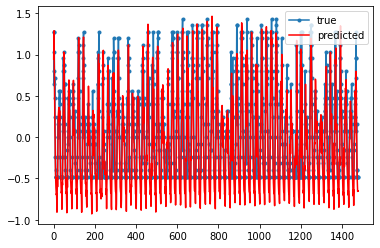

In [ ]:
data = load_data(historical_data)
data = data[[inputColumn, outputColumn]].copy()
data = process_data(data)

shiftDays = 1 
shiftSteps = shiftDays * 24

#shiftedData = data
#shiftedData[outputColumn] = shiftedData[outputColumn].shift(-shiftSteps)

shiftedData = data[outputColumn].shift(-shiftSteps)

print(data[outputColumn].head(shiftSteps + 5))
print(shiftedData.head(5))
print(shiftedData.tail()) #this should be NaN, since the data has been shifted backwards (down)

data[outputColumn] = shiftedData
data = splitData(data)
print(f'Split shifted data: {splitData(data)}')
#print(f'Split shifted data: {splitData(shiftedData)}')

train = transformData(data[0], [inputColumn, outputColumn])
test = transformData(data[1], [inputColumn, outputColumn])

print(f'Test data: {test}')
input, output = createDatasets(train, train[outputColumn], steps)

print(f'Dataset shape set to: {input.shape, output.shape}')
print(f'Set model input shape to: {input.shape[1], input.shape[2]}')
print(f'Test data: {output}')


model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(input.shape[1], input.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

model = compile(model)
#model.compile(loss='mean_squared_error', optimizer='adam')
history = fit(model, input, output)

testInput, testOutput = createDatasets(test, test[outputColumn], steps)

print(f'Test data shape: {testInput.shape}')
print(f'Input: {testInput[1][0]}')
prediction = make_prediction(model, testInput, False)
print(prediction)

print(f'Prediction output shape: {inverseTransformData(prediction).shape}')
print(f'Prediction values: {inverseTransformData(prediction)}')

print(f'Real values: {data[1].head(20)}')
#print(f'Real values: {inverseTransformData(np.reshape(testOutput,(-1,1)))}')
look = inverseTransformData(np.reshape(testOutput,(-1,1)))
#print(look[-20:, :])
#print(f'Shapes {testOutput.shape, look.shape}')
plt.plot(inverseTransformData(np.reshape(testOutput,(-1,1))).flatten(), marker='.', label='true')
plt.plot(inverseTransformData(prediction).flatten(), 'r', label='predicted')
plt.legend()


**Test**

In [ ]:
model = load_model(model_path)

model.summary()

testInput = process_data(load_data(rData_path))
print(testInput[0:4])
testInput = testInput*np.pi / 180 #radians

print(testInput)
#test = np.array(testInput[10677:10677+48])
test = np.array(testInput[0:48])
test_mean = test.mean()
test_std = test.std()

test = (test - test_mean) / test_std

test = test.reshape(1,24,2)
print(f'TEST SHAPE: {test.shape}')

preds = model.predict(test, verbose=0)
print(f'PREDICTON: {preds}')


data = pd.read_csv(rData_path, sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')

trueData = data[[diffused]].copy()

#trueData = np.array(trueData[10677:10677+48])
trueData = np.array(trueData[0:48])
trueData = trueData.reshape(1,48,1)
trueData_mean = trueData.mean()
trueData_std = trueData.std()

trueData = (trueData - trueData_mean) / trueData_std

#show = load_data(rData_path)
#print(trueData)


#test_results = model.evaluate(preds, trueData, verbose=0)
#print(f" Accuracy: {test_results}")


data = pd.read_csv(rData_path, sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')

trueData = data[[diffused]].copy()
trueData = np.array(trueData)
trueData_mean = trueData.mean()
trueData_std = trueData.std()

trueData = (trueData - trueData_mean) / trueData_std

print(trueData[0:48])
#print(trueData[10677])
            


OSError: ignored